# Importing, authenticating and initialising. 

In [36]:
!pip install geemap

Might have to restart the kernel after running the download to get `import geemap.eefolium as geemap` to work 

In [37]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping, Polygon, shape
import pandas as pd
import ee
import folium

from datetime import datetime, timedelta, timezone
from ml4floods.data import ee_download
import os

import geemap.eefolium as geemap
import fsspec

import json


In [38]:
ee.Authenticate()

Enter verification code:  4/1ARtbsJrfeD2L-CcF-g0nXWm4L1TpOgzDMBZTyqaCLvyAAwl2mrpVsWZOjBQ



Successfully saved authorization token.


In [39]:
ee.Initialize()

In [40]:
ls

intersections_sketchpad.ipynb  visualisation_sketchpad.ipynb
query_sketchpad2.ipynb


In [41]:
sydney20_df = gpd.read_file('../../data/sydney20_df.shp')

In [42]:
sydney20_df.head()

,id,cloud_cove,source,aoi_code,percentage,geometry
0,2021-08-13,0.02,landsat,AOI01,1.000000,"POLYGON ((147.09960 -31.24462, 147.09960 -31.0..."
1,2021-08-29,14.17,landsat,AOI01,1.000000,"POLYGON ((147.09960 -31.24462, 147.09960 -31.0..."
2,2021-08-04,1.96,landsat,AOI01,0.279306,"POLYGON ((147.09960 -31.24462, 147.09960 -31.0..."
3,2021-08-20,0.01,landsat,AOI01,0.276128,"POLYGON ((147.09960 -31.24462, 147.09960 -31.0..."
4,2021-08-13,0.02,landsat,AOI01,1.000000,"POLYGON ((147.09960 -31.04462, 147.09960 -30.8..."


Haven't been able to figure out why 'cloud_cover' column is missing an 'r'. 

In [43]:
if 'cloud_cove' in sydney20_df.columns: sydney20_df.rename(columns={'cloud_cove' : 'cloud_cover'}, inplace = True)

In [44]:
sydney20_df.columns

Index(['id', 'cloud_cover', 'source', 'aoi_code', 'percentage', 'geometry'], dtype='object')

Ensuring the geometry column is a geoseries so that we can use the `explore()` function

In [45]:
type(sydney20_df['geometry'])

geopandas.geoseries.GeoSeries

In [46]:
if type(sydney20_df['geometry']) is gpd.geoseries.GeoSeries: print('true')

true


# Visualisations

## Checking some properties of the DF

Number of images per date (head)

In [47]:
sydney20_df.groupby(['id']).count().head()

,cloud_cover,source,aoi_code,percentage,geometry
id,,,,,
2021-08-03,4,4,4,4,4
2021-08-04,3,3,3,3,3
2021-08-05,20,20,20,20,20
2021-08-06,15,15,15,15,15
2021-08-08,4,4,4,4,4


Number of images for each source per date

In [48]:
sydney20_df.groupby(['id','source']).count()

cloud_cover  aoi_code  percentage  geometry
id         source                                              
2021-08-03 s2                 4         4           4         4
2021-08-04 landsat            3         3           3         3
2021-08-05 s2                20        20          20        20
2021-08-06 landsat           15        15          15        15
2021-08-08 s2                 4         4           4         4
2021-08-10 s2                20        20          20        20
2021-08-13 landsat           20        20          20        20
           s2                 4         4           4         4
2021-08-15 s2                20        20          20        20
2021-08-18 s2                 4         4           4         4
2021-08-20 landsat            3         3           3         3
           s2                20        20          20        20
2021-08-22 landsat           15        15          15        15
2021-08-23 s2                 4         4           4         4
2021-08-25 s2                20        20          20        20
2021-08-28 s2                 4         4           4         4
2021-08-29 landsat           20        20          20        20
2021-08-30 s2                20        20          20        20
2021-09-02 s2                 4         4           4         4

The above shows some dates have only one particular source and other dates have both sources. 

## Specific AOI cloud cover

Plotting a single AOI cloud cover over the timeperiod the AOI has images for. Needed to use `drop_duplicates()` as there are duplicate dates with the same `cloud_cover` but different `valid_pixels`

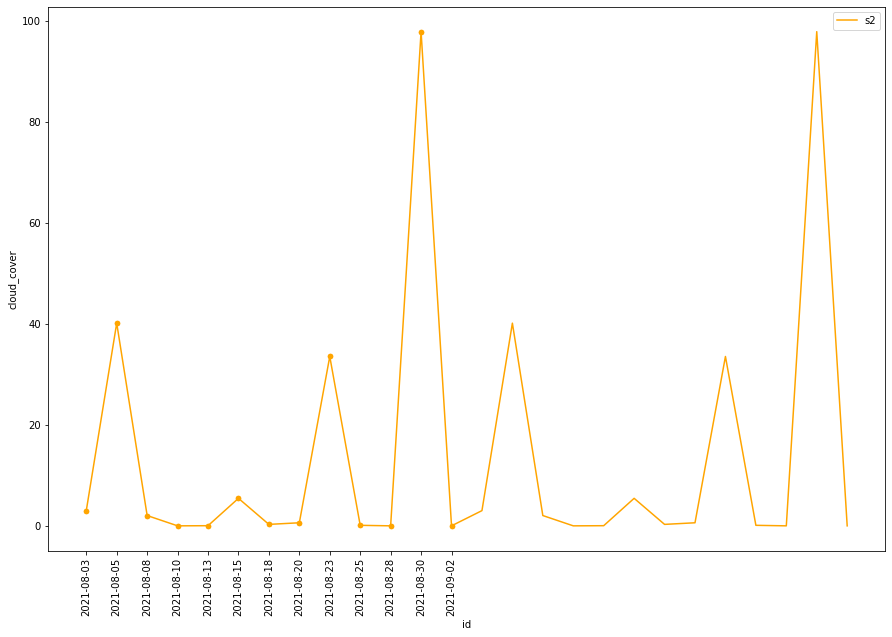

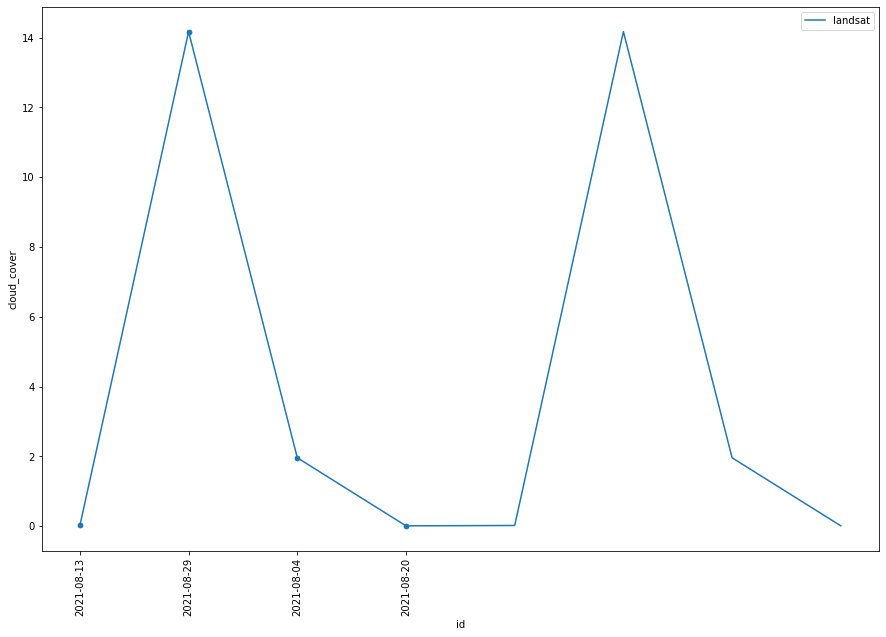

In [49]:
ax = sydney20_df[(sydney20_df['source'] == 's2') & (sydney20_df['aoi_code'] == 'AOI01')].plot(kind= 'scatter', x = 'id', y= 'cloud_cover', figsize = (15,10), color = 'orange')
sydney20_df[(sydney20_df['source'] == 's2') & (sydney20_df['aoi_code'] == 'AOI01')].plot(kind= 'line', x = 'id', y= 'cloud_cover', figsize = (15,10), color = 'orange', label = 's2', ax = ax)

plt.xticks(rotation=90)
plt.show()

ax2= sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['aoi_code'] == 'AOI01')].plot(kind= 'scatter', x = 'id', y= 'cloud_cover', figsize = (15,10), legend = 'source')
sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['aoi_code'] == 'AOI01')].plot(kind= 'line', x = 'id', y= 'cloud_cover', figsize = (15,10), legend = 'source', label = 'landsat', ax= ax2)

# sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['aoi_code'] == 'AOI01')].drop_duplicates(subset = 'id').plot(kind= 'scatter', x = 'id', y= 'cloud_cover', figsize = (15,10), legend = 'source', ax=ax)
# sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['aoi_code'] == 'AOI01')].drop_duplicates(subset = 'id').plot(kind= 'line', x = 'id', y= 'cloud_cover', figsize = (15,10), legend = 'source', label = 'landsat', ax= ax)


plt.xticks(rotation=90)
plt.show()

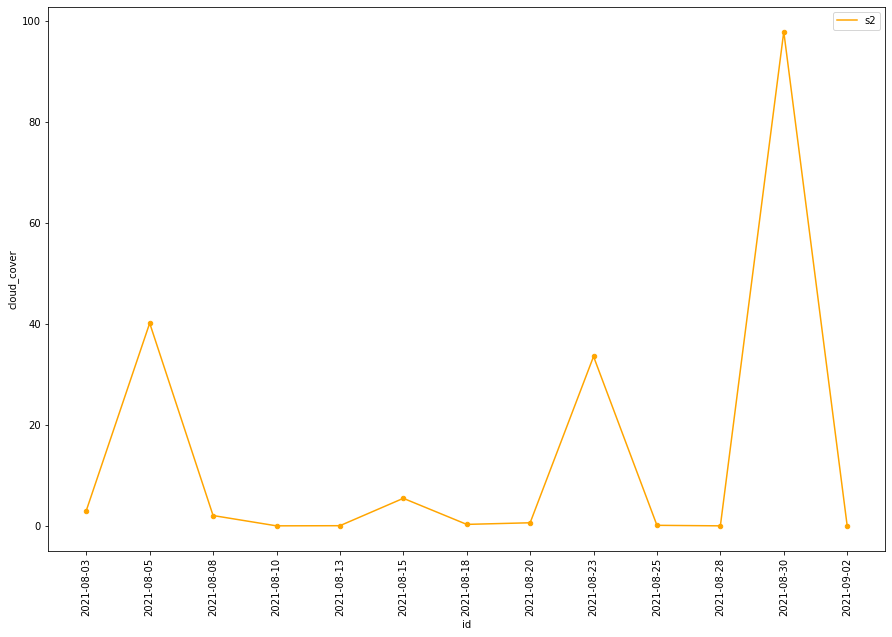

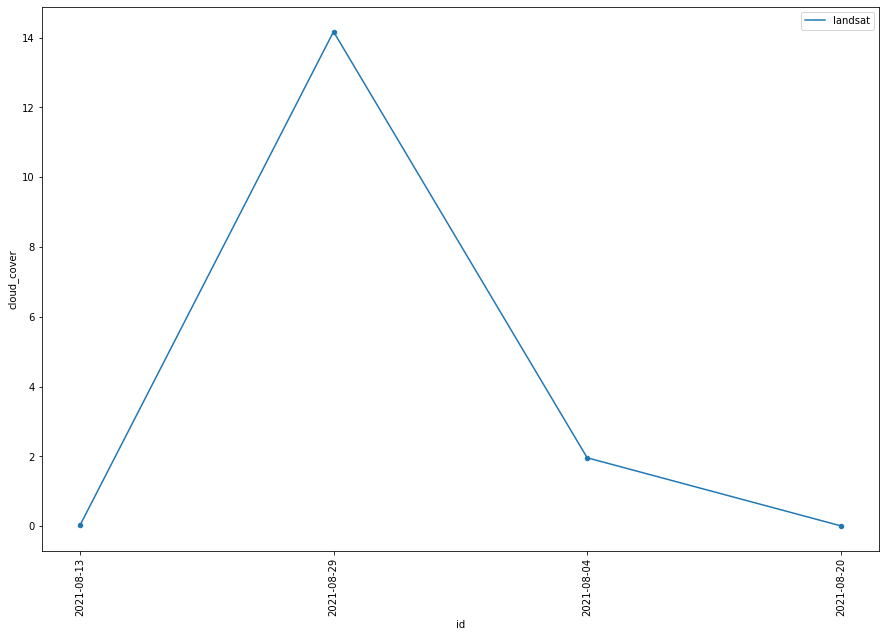

In [50]:
ax = sydney20_df[(sydney20_df['source'] == 's2') & (sydney20_df['aoi_code'] == 'AOI01')].drop_duplicates(subset = 'id').plot(kind= 'scatter', x = 'id', y= 'cloud_cover', figsize = (15,10), color = 'orange')
sydney20_df[(sydney20_df['source'] == 's2') & (sydney20_df['aoi_code'] == 'AOI01')].drop_duplicates(subset = 'id').plot(kind= 'line', x = 'id', y= 'cloud_cover', figsize = (15,10), color = 'orange', label = 's2', ax = ax)
plt.xticks(rotation=90)
plt.show()
ax2= sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['aoi_code'] == 'AOI01')].drop_duplicates(subset = 'id').plot(kind= 'scatter', x = 'id', y= 'cloud_cover', figsize = (15,10), legend = 'source')
sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['aoi_code'] == 'AOI01')].drop_duplicates(subset = 'id').plot(kind= 'line', x = 'id', y= 'cloud_cover', figsize = (15,10), legend = 'source', label = 'landsat', ax= ax2)

# sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['aoi_code'] == 'AOI01')].drop_duplicates(subset = 'id').plot(kind= 'scatter', x = 'id', y= 'cloud_cover', figsize = (15,10), legend = 'source', ax=ax)
# sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['aoi_code'] == 'AOI01')].drop_duplicates(subset = 'id').plot(kind= 'line', x = 'id', y= 'cloud_cover', figsize = (15,10), legend = 'source', label = 'landsat', ax= ax)


plt.xticks(rotation=90)
plt.show()

Trying to put them on the same figures

In [51]:
sydney20_df[(sydney20_df['source'] == 's2') & (sydney20_df['aoi_code'] == 'AOI01')].size

156

In [52]:
sydney20_df[(sydney20_df['source'] == 's2') & (sydney20_df['aoi_code'] == 'AOI01')].drop_duplicates(subset = 'id').size

78

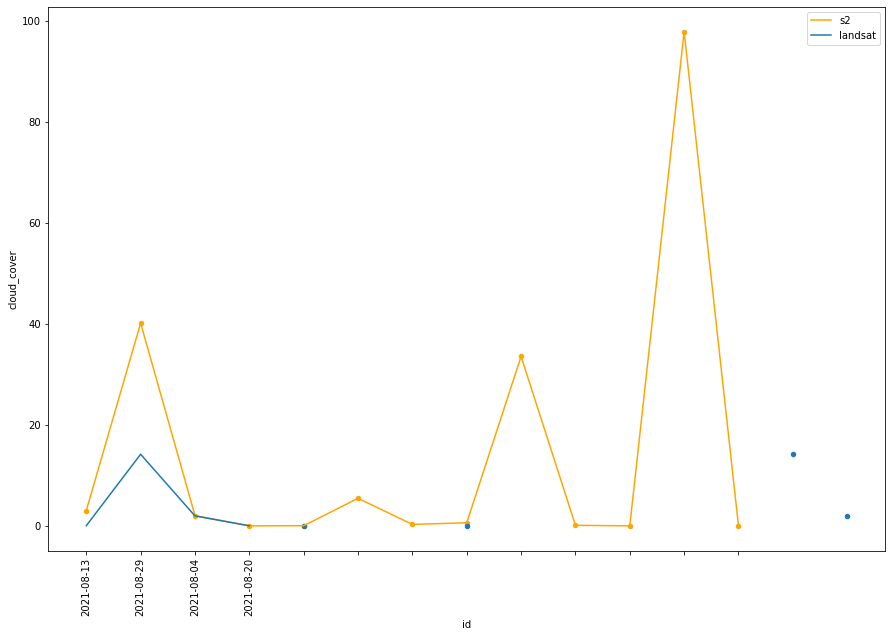

In [53]:
ax = sydney20_df[(sydney20_df['source'] == 's2') & (sydney20_df['aoi_code'] == 'AOI01')].drop_duplicates(subset = 'id').plot(kind= 'scatter', x = 'id', y= 'cloud_cover', figsize = (15,10), color = 'orange')
sydney20_df[(sydney20_df['source'] == 's2') & (sydney20_df['aoi_code'] == 'AOI01')].drop_duplicates(subset = 'id').plot(kind= 'line', x = 'id', y= 'cloud_cover', figsize = (15,10), color = 'orange', label = 's2', ax = ax)

sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['aoi_code'] == 'AOI01')].drop_duplicates(subset = 'id').plot(kind= 'scatter', x = 'id', y= 'cloud_cover', figsize = (15,10), legend = 'source', ax=ax)
sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['aoi_code'] == 'AOI01')].drop_duplicates(subset = 'id').plot(kind= 'line', x = 'id', y= 'cloud_cover', figsize = (15,10), legend = 'source', label = 'landsat', ax= ax)


plt.xticks(rotation=90)
plt.show()

Making a plotting function

In [54]:
def cloudCover_period(aoiStr : str):
    ax = sydney20_df[(sydney20_df['source'] == 's2') & (sydney20_df['aoi_code'] == aoiStr)].drop_duplicates(subset = 'id').plot(kind= 'scatter', x = 'id', y= 'cloud_cover', figsize = (15,10), color = 'orange')
    sydney20_df[(sydney20_df['source'] == 's2') & (sydney20_df['aoi_code'] == aoiStr)].drop_duplicates(subset = 'id').plot(kind= 'line', x = 'id', y= 'cloud_cover', figsize = (15,10), color = 'orange', ax = ax)

    plt.xticks(rotation=90)
    plt.title(f'S2 cloud cover for {aoiStr}')
    plt.show()


    ax2= sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['aoi_code'] == aoiStr)].drop_duplicates(subset = 'id').plot(kind= 'scatter', x = 'id', y= 'cloud_cover', figsize = (15,10), legend = 'source')
    sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['aoi_code'] == aoiStr)].drop_duplicates(subset = 'id').plot(kind= 'line', x = 'id', y= 'cloud_cover', figsize = (15,10), legend = 'source', ax= ax2)


    plt.xticks(rotation=90)
    plt.title(f'Landsat cloud cover for {aoiStr}')
    plt.show()

Testing the function for a new aoi.

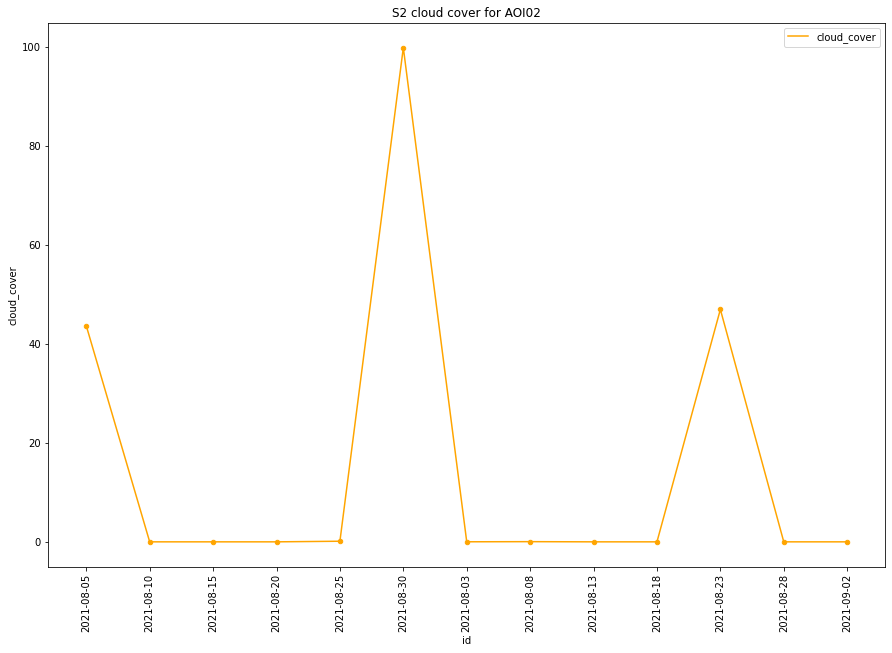

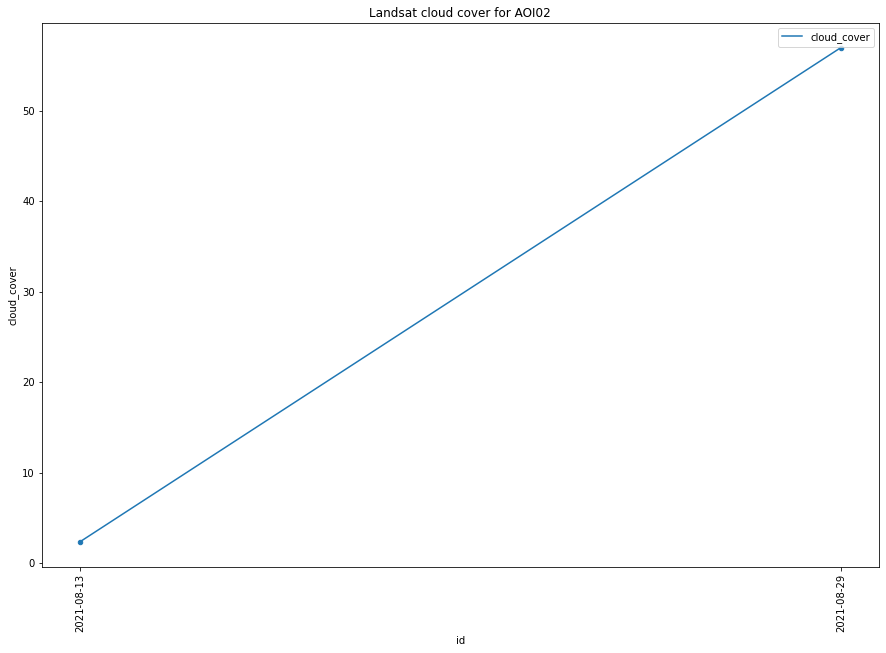

In [55]:
cloudCover_period('AOI02')

## Interactive map to check AOIs for desired source

In [56]:
sydney20_df.explore(tooltip = 'aoi_code', column= 'aoi_code', popup= True, style_kwds= dict(color= 'black'), cmap = 'Set1')

In [57]:
sydney20_df[sydney20_df['source'] == 'landsat'].sort_values(by = 'id').head()

,id,cloud_cover,source,aoi_code,percentage,geometry
2,2021-08-04,1.96,landsat,AOI01,0.279306,"POLYGON ((147.09960 -31.24462, 147.09960 -31.0..."
6,2021-08-04,1.96,landsat,AOI01,0.521599,"POLYGON ((147.09960 -31.04462, 147.09960 -30.8..."
14,2021-08-04,1.96,landsat,AOI0289,0.763331,"POLYGON ((147.09960 -30.84462, 147.09960 -30.6..."
48,2021-08-06,54.69,landsat,AOI0368,1.000000,"POLYGON ((148.09960 -32.24461, 148.09960 -32.0..."
28,2021-08-06,54.69,landsat,AOI0316,0.990823,"POLYGON ((147.89960 -32.44461, 147.89960 -32.2..."


In [58]:
sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['id'] == '2021-08-13')].head()

,id,cloud_cover,source,aoi_code,percentage,geometry
0,2021-08-13,0.02,landsat,AOI01,1.0,"POLYGON ((147.09960 -31.24462, 147.09960 -31.0..."
4,2021-08-13,0.02,landsat,AOI01,1.0,"POLYGON ((147.09960 -31.04462, 147.09960 -30.8..."
8,2021-08-13,2.36,landsat,AOI02,1.0,"POLYGON ((147.49960 -32.44461, 147.49960 -32.2..."
10,2021-08-13,0.02,landsat,AOI02,1.0,"POLYGON ((147.49960 -30.44461, 147.49960 -30.2..."
12,2021-08-13,0.02,landsat,AOI0289,1.0,"POLYGON ((147.09960 -30.84462, 147.09960 -30.6..."


Landsat on a specific day

In [59]:
sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['id'] == '2021-08-13')].explore(tooltip = 'aoi_code', column= 'aoi_code', popup= True, style_kwds= dict(color= 'black'))

In [60]:
sydney20_df[(sydney20_df['source'] == 'landsat') & (sydney20_df['id'] == '2021-08-13')].explore(tooltip = 'aoi_code', column= 'cloud_cover', popup= True, style_kwds= dict(color= 'black'))

In [61]:
def aoiExplore(sourceStr: str, dateStr: str, propertyStr: str):
    return(sydney20_df[(sydney20_df['id'] == dateStr) & (sydney20_df['source'] == sourceStr)].explore(tooltip = 'aoi_code', column= propertyStr, popup= True, style_kwds= dict(color= 'black')))

In [62]:
aoiExplore('landsat', '2021-08-13', 'cloud_cover')

In [63]:
aoiExplore('landsat', '2021-08-13', 'percentage')

In [64]:
aoiExplore('s2', '2021-08-13', 'percentage')

/opt/conda/lib/python3.7/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars
  gadf = 1 - self.adcm / adam


# `geemap` visualisations

## Example

Taken from `HOWTO_inference_on_image_time_series.ipynb` [seen here](http://trillium.tech/ml4floods/content/ml4ops/HOWTO_inference_on_image_time_series.html)

In [65]:
date_event = datetime.strptime("2021-02-12","%Y-%m-%d").replace(tzinfo=timezone.utc)

date_start_search = datetime.strptime("2021-01-15","%Y-%m-%d").replace(tzinfo=timezone.utc)
date_end_search = date_start_search + timedelta(days=45)

area_of_interest_geojson = {'type': 'Polygon',
 'coordinates': (((19.483318354000062, 41.84407200000004),
   (19.351701478000052, 41.84053242300007),
   (19.298659824000026, 41.871157520000054),
   (19.236388306000038, 41.89588351100008),
   (19.22956438700004, 42.086957306000045),
   (19.327827977000027, 42.09102668200006),
   (19.778082109000025, 42.10312055000003),
   (19.777652446000047, 41.97309238100007),
   (19.777572772000042, 41.94912981900006),
   (19.582705341000064, 41.94398333100003),
   (19.581417139000052, 41.94394820700006),
   (19.54282145700006, 41.90168177700008),
   (19.483318354000062, 41.84407200000004)),)}

area_of_interest = shape(area_of_interest_geojson) # turns the above aoi into a shape, this is the shape that
                                                    # will be plotted on the map

def generate_polygon(bbox):
    """
    Generates a list of coordinates: [[x1,y1],[x2,y2],[x3,y3],[x4,y4],[x1,y1]]
    """
    return [[bbox[0],bbox[1]],
             [bbox[2],bbox[1]],
             [bbox[2],bbox[3]],
             [bbox[0],bbox[3]],
             [bbox[0],bbox[1]]]

In [66]:
area_of_interest_geojson

{'type': 'Polygon',
 'coordinates': (((19.483318354000062, 41.84407200000004),
   (19.351701478000052, 41.84053242300007),
   (19.298659824000026, 41.871157520000054),
   (19.236388306000038, 41.89588351100008),
   (19.22956438700004, 42.086957306000045),
   (19.327827977000027, 42.09102668200006),
   (19.778082109000025, 42.10312055000003),
   (19.777652446000047, 41.97309238100007),
   (19.777572772000042, 41.94912981900006),
   (19.582705341000064, 41.94398333100003),
   (19.581417139000052, 41.94394820700006),
   (19.54282145700006, 41.90168177700008),
   (19.483318354000062, 41.84407200000004)),)}

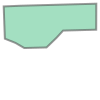

In [67]:
area_of_interest

Found 18 S2 images between 2021-02-12T00:00:00+00:00 and 2021-03-01T00:00:00+00:00


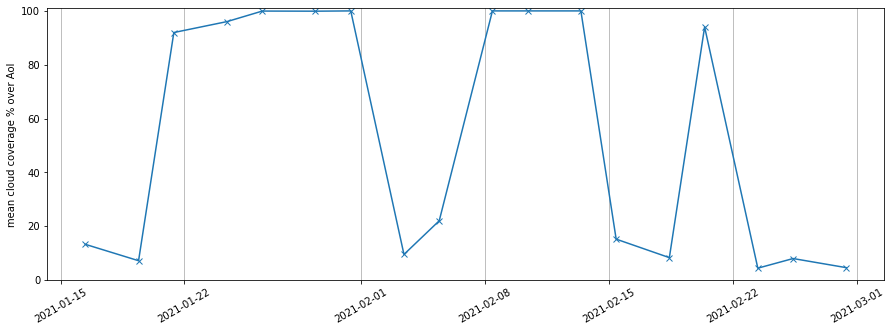

In [68]:
bounds_pol = generate_polygon(area_of_interest.bounds)
pol_2_clip = ee.Geometry.Polygon(bounds_pol)

pol = ee.Geometry(area_of_interest_geojson)

# Grab the S2 images and the Permanent water image
img_col = ee_download.get_s2_collection(date_start_search, 
                                        date_end_search, pol)

permanent_water_img = ee_download.permanent_water_image(date_event.year, pol_2_clip)

# Get info of the S2 images (convert to table)
img_col_info = ee_download.img_collection_to_feature_collection(img_col, 
                                                                ["system:time_start", "valids", "cloud_probability"])

img_col_info_local = gpd.GeoDataFrame.from_features(img_col_info.getInfo())
img_col_info_local["valids"]*=100
img_col_info_local["system:time_start"] = img_col_info_local["system:time_start"].apply(lambda x: datetime.utcfromtimestamp(x/1000))

n_images_col = img_col_info_local.shape[0]
print(f"Found {n_images_col} S2 images between {date_event.isoformat()} and {date_end_search.isoformat()}")

plt.figure(figsize=(15,5))
plt.plot(img_col_info_local["system:time_start"], img_col_info_local["cloud_probability"],marker="x")
plt.ylim(0,101)
plt.xticks(rotation=30)
plt.ylabel("mean cloud coverage % over AoI")
plt.grid(axis="x")

In [69]:
bounds_pol

[[19.22956438700004, 41.84053242300007],
 [19.778082109000025, 41.84053242300007],
 [19.778082109000025, 42.10312055000003],
 [19.22956438700004, 42.10312055000003],
 [19.22956438700004, 41.84053242300007]]

In [70]:
Map = geemap.Map()

imgs_list = img_col.toList(n_images_col, 0)
for i in range(n_images_col):
    if img_col_info_local.iloc[i]["cloud_probability"] > 75:
        continue
    img_show = ee.Image(imgs_list.get(i))
    
    Map.addLayer(img_show.clip(pol), 
                 {"min":0, "max":3000, 
                  "bands":["B11","B8","B4"]},
                 f"({i}/{n_images_col}) S2 SWIR/NIR/RED {img_col_info_local['system:time_start'][i].strftime('%Y-%m-%d')}", 
                 True)


visualization = {
  "bands": ['waterClass'],
  "min": 0.0,
  "max": 3.0,
  "palette": ['cccccc', 'ffffff', '99d9ea', '0000ff']
}

Map.addLayer(permanent_water_img, visualization, name="JRC Permanent water")

Map.addLayer(pol, {"color": 'FF000000'}, "AoI")

Map.centerObject(pol, zoom=11)
folium.LayerControl(collapsed=False).add_to(Map)
Map

Things to note: 
* Gonzalo used 'cloud_probability' > 75 property.


## Plotting the image swath, no layers added

Total size of image swath aoi, will be a big square due to the swaths. Use `generate_polygon` to turn it into a polygon. The put it into an aoi geojson form to be read into `ee`.

In [71]:
aoi = tuple(generate_polygon(sydney20_df['geometry'].total_bounds))
aoi

([147.09959654580408, -32.84460560526438],
 [148.50960316085715, -32.84460560526438],
 [148.50960316085715, -30.234605605264342],
 [147.09959654580408, -30.234605605264342],
 [147.09959654580408, -32.84460560526438])

In [72]:
testArea_of_interest_geojson = {'type': 'Polygon',
 'coordinates': ((aoi),)}

Putting it in correct for to use in `ee.Geometry()`

In [73]:
testArea_of_interest_geojson

{'type': 'Polygon',
 'coordinates': (([147.09959654580408, -32.84460560526438],
   [148.50960316085715, -32.84460560526438],
   [148.50960316085715, -30.234605605264342],
   [147.09959654580408, -30.234605605264342],
   [147.09959654580408, -32.84460560526438]),)}

In [74]:
testPol = ee.Geometry(testArea_of_interest_geojson)

In [75]:
testPol_2_clip = ee.Geometry.Polygon(aoi)

In [76]:
testPermanent_water_img = ee_download.permanent_water_image(date_event.year, testPol_2_clip)

Some areas had less permanent water than expected. We expect a full body of water to be labelled as permanent water, no? 

In [77]:
Map = geemap.Map()

visualization = {
  "bands": ['waterClass'],
  "min": 0.0,
  "max": 3.0,
  "palette": ['cccccc', 'ffffff', '99d9ea', '0000ff']
}

Map.addLayer(testPermanent_water_img, visualization, name="JRC Permanent water")

Map.addLayer(testPol, {"color": 'FF000000'}, "AoI")

Map.centerObject(testPol, zoom=11)
folium.LayerControl(collapsed=False).add_to(Map)
Map

## Plotting the AOIs, no added layers

Number of AOIs in this particular AOI:

In [78]:
sydney20_df[(sydney20_df['aoi_code'] == 'AOI01')]['geometry'].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,  76,  77,  78,  79,  80,
             81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
             94,  95,  96,  97,  98,  99, 100, 101],
           dtype='int64')

In [79]:
sydney20_df[(sydney20_df['aoi_code'] == 'AOI01')]['geometry'].index.size

34

In [80]:
sydney20_df[(sydney20_df['aoi_code'] == 'AOI01')]['geometry']

0      POLYGON ((147.09960 -31.24462, 147.09960 -31.0...
1      POLYGON ((147.09960 -31.24462, 147.09960 -31.0...
2      POLYGON ((147.09960 -31.24462, 147.09960 -31.0...
3      POLYGON ((147.09960 -31.24462, 147.09960 -31.0...
4      POLYGON ((147.09960 -31.04462, 147.09960 -30.8...
5      POLYGON ((147.09960 -31.04462, 147.09960 -30.8...
6      POLYGON ((147.09960 -31.04462, 147.09960 -30.8...
7      POLYGON ((147.09960 -31.04462, 147.09960 -30.8...
76     POLYGON ((147.09960 -31.24462, 147.09960 -31.0...
77     POLYGON ((147.09960 -31.24462, 147.09960 -31.0...
78     POLYGON ((147.09960 -31.24462, 147.09960 -31.0...
79     POLYGON ((147.09960 -31.24462, 147.09960 -31.0...
80     POLYGON ((147.09960 -31.24462, 147.09960 -31.0...
81     POLYGON ((147.09960 -31.24462, 147.09960 -31.0...
82     POLYGON ((147.09960 -31.24462, 147.09960 -31.0...
83     POLYGON ((147.09960 -31.24462, 147.09960 -31.0...
84     POLYGON ((147.09960 -31.24462, 147.09960 -31.0...
85     POLYGON ((147.09960 -31.

In [81]:
for i in list(sydney20_df[(sydney20_df['aoi_code'] == 'AOI01')]['geometry'].index):
    sydney20_df[(sydney20_df['aoi_code'] == 'AOI01')]['geometry'][i]
    # print(i)

In [82]:
def read_aoi(my_gpd_aoi:str):
    my_aoi = gpd.read_file(my_gpd_aoi)
    
    aoi_codes = my_aoi['aoi_code']
    js = json.loads(my_aoi.to_json()) # converting the aoi to a json and getting the 
    bounds = ee.Geometry(ee.FeatureCollection(js).geometry())
    
    return bounds, aoi_codes

In [83]:
sydney_aoi, sydney_aoi_codes = read_aoi('../../data/2022-07-21_aois.geojson')

In [84]:
testArea_of_interest_geojson2 = sydney_aoi.getInfo()

In [85]:
testArea_of_interest2 = shape(testArea_of_interest_geojson2) # turns the above aoi into a shape, this is the shape that

In [86]:
testPol2 = ee.Geometry(testArea_of_interest_geojson2)

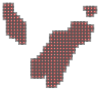

In [87]:
testArea_of_interest2

In [88]:
testPol_2_clip2 = ee.Geometry.Polygon(testArea_of_interest2.bounds)

In [89]:
Map = geemap.Map()

visualization = {
  "bands": ['waterClass'],
  "min": 0.0,
  "max": 3.0,
  "palette": ['cccccc', 'ffffff', '99d9ea', '0000ff']
}

Map.addLayer(testPermanent_water_img, visualization, name="JRC Permanent water")

Map.addLayer(testPol2, {"color": 'FF000000'}, "AoI")

Map.centerObject(testPol, zoom=11)
folium.LayerControl(collapsed=False).add_to(Map)
Map

## Putting the AOIs and the swaths together, no added layers

In [90]:
Map = geemap.Map()

visualization = {
  "bands": ['waterClass'],
  "min": 0.0,
  "max": 3.0,
  "palette": ['cccccc', 'ffffff', '99d9ea', '0000ff']
}

Map.addLayer(testPermanent_water_img, visualization, name="JRC Permanent water")

Map.addLayer(testPol, {"color": '999999'}, "AoI")
Map.addLayer(testPol2, {"color": '990000'}, "AoI2")

Map.centerObject(testPol, zoom=6)
folium.LayerControl(collapsed=False).add_to(Map)
Map

# End